In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip 

--2019-12-08 23:58:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  14.5MB/s    in 2.8s    

2019-12-08 23:58:36 (14.5 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]



In [3]:
!unzip drugsCom_raw.zip 

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [4]:
import pandas as pd
df_test = pd.read_csv('drugsComTest_raw.tsv',delimiter='\t')     # Read the files with the pandas dataFrame
df_train = pd.read_csv('drugsComTrain_raw.tsv', delimiter='\t')
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [0]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [6]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
stemmer = SnowballStemmer('english')
def review_to_words(raw_review): 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stops]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return( ' '.join(stemming_words))

In [10]:
df_all['review_clean'] = df_all['review'].apply(review_to_words)
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)
df_all['sentiment'].value_counts()

1    148646
0     63407
Name: sentiment, dtype: int64

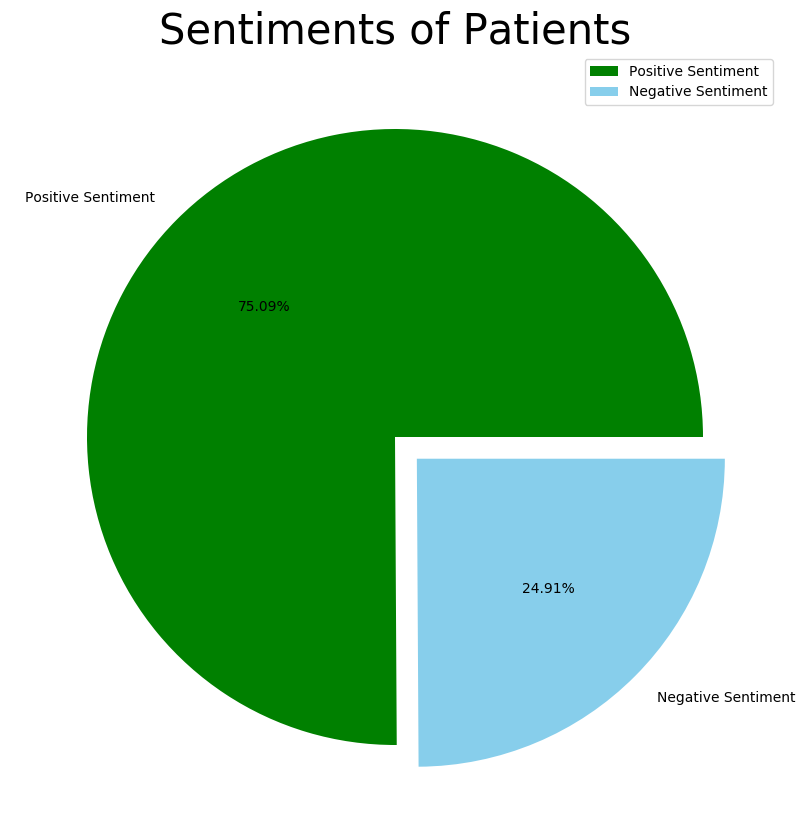

In [11]:
import matplotlib.pyplot as plt
size = [161491, 53572]
colors = ['green', 'skyblue']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]
plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Sentiments of Patients', fontsize = 30)
plt.legend()
plt.show()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer
pipeline = Pipeline([
    ('vect', vectorizer),
])

from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf.get_n_splits(df_all)
KFold(n_splits=2, random_state=None, shuffle=False)

KFold(n_splits=2, random_state=None, shuffle=False)

In [0]:
all_data = pipeline.fit_transform(df_all['review_clean'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(all_data, df_all['sentiment'], test_size=0.33, random_state=42) 

In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
import tensorflow as tf

model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(200, input_shape=(20000,)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation('relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(300))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation('relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(100, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

graph2 = model2.fit(X_train, y_train, epochs=10, batch_size=64)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4000200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               60300     
_____________________________________

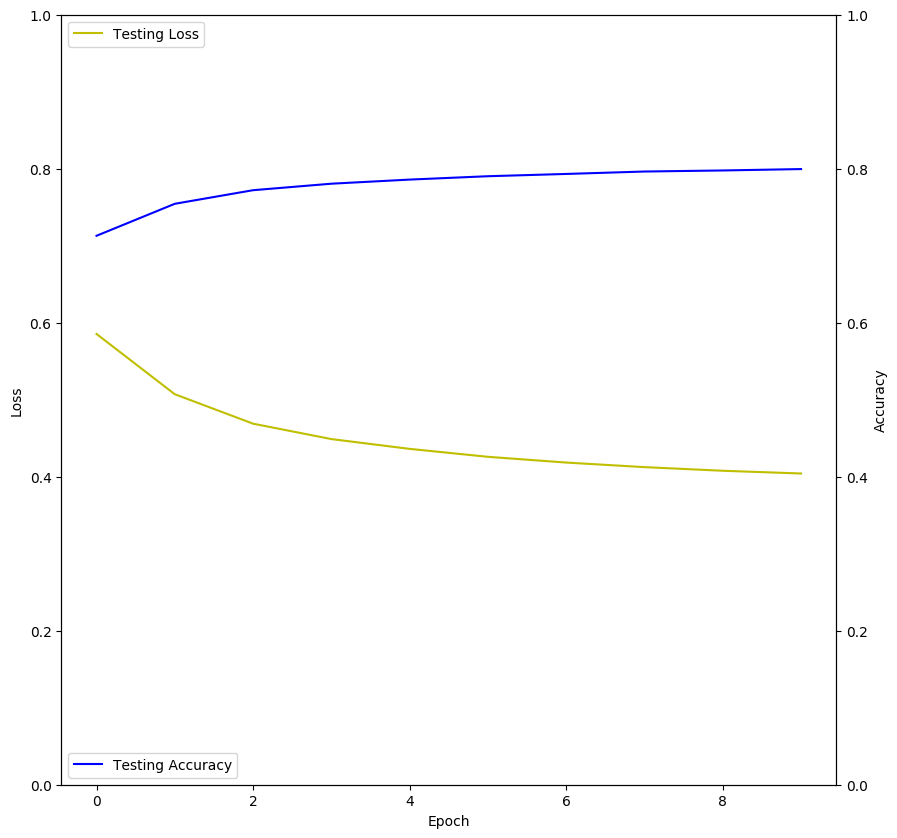

In [16]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])
loss_ax.plot(graph2.history['loss'], 'y', label='Testing Loss')
acc_ax.plot(graph2.history['acc'], 'b', label='Testing Accuracy')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
acc_ax.set_ylabel('Accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [17]:
model2_score_test = model2.evaluate(X_test, y_test, batch_size=32)
model2_score_train = model2.evaluate(X_train, y_train, batch_size=32)
print("Accuracy for Long-Short Term Memory is ",model2_score_train[1])

142075/142075 [==============================] - 14s 101us/step
Accuracy for Long-Short Term Memory is  0.8088896709480232


In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

model1 = RandomForestClassifier(n_estimators=100)

graph1 = model1.fit(X_train, y_train)

In [19]:
model1_scores = model1.score(X_test,y_test)

print('Accuracy for Random Forest = '+ str(model1_scores))

Accuracy for Random Forest = 0.7570665066163651


In [20]:
model1_predictions = model1.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(model1_predictions,y_test))
print(classification_report(model1_predictions,y_test))
print(accuracy_score(model1_predictions,y_test))

[[ 6944  2935]
 [14065 46034]]
              precision    recall  f1-score   support

           0       0.33      0.70      0.45      9879
           1       0.94      0.77      0.84     60099

    accuracy                           0.76     69978
   macro avg       0.64      0.73      0.65     69978
weighted avg       0.85      0.76      0.79     69978

0.7570665066163651


In [0]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import compute_class_weight
from keras import optimizers
from sklearn.utils import shuffle
from keras.utils import to_categorical

In [22]:
df_train = shuffle(df_train)
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
61482,45048,Fluoxetine,Depression,"""This medication made me yawn frequently. Afte...",2.0,"January 7, 2017",18
39842,89335,Celexa,Depression,"""I&#039;ve taken this medication for about 3:y...",9.0,"August 5, 2015",60
12098,230693,Cyclizine,Motion Sickness,"""I&#039;m a medical doctor (anesthesiologist),...",10.0,"June 3, 2009",81
88803,135963,Acamprosate,Alcohol Dependence,"""I have been in two 28 day in patient programs...",10.0,"May 3, 2015",112
91121,210944,Mirtazapine,Insomnia,"""THIS DRUG SHOULD BE BANNED..... I started on ...",1.0,"February 12, 2016",51


In [0]:
df_train['review'] = df_train['review'].str.replace("&#039;", "'", regex=False)

In [0]:
r = df_train['rating']
labels = \
1* ((0 <= r) & ( r <= 2))  \
+ 2*((3 <= r) & (r <= 4)) \
+ 3*((5 <= r) & (r <= 6)) \
+ 4*((7 <= r) & (r <= 8)) \
+ 5*((9 <= r) & (r <= 10))

labels = labels -1 

df_train['label'] = labels

In [25]:
df_train['review_length'] = df_train['review'].apply(len)
df_train['review_length'].describe()

count    160398.000000
mean        450.730383
std         237.851351
min           3.000000
25%         258.000000
50%         447.000000
75%         679.000000
max       10547.000000
Name: review_length, dtype: float64

In [0]:
MOSTCOMMONWORDS = 2000
REVIEWLENGTH = 500
SAMPLES = 10000
WORDEMBEDDIM = 12
EPOCHS = 10
VERBOSE = 2
BATCHSIZE = 32
VALIDATIONPERCENT = 0.25

In [27]:
samples = df_train['review'].iloc[:SAMPLES]
import nltk
import urllib.request
import math
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
def stopword_and_lemmatize(review): 
    tokens = review.split()
    tokens=[token.lower() for token in tokens if token.isalpha()]
    sw = stopwords.words('english')
    ctokens = tokens
    for token in tokens:
        if token in sw:
            ctokens.remove(token)            
    lemmatizer = WordNetLemmatizer()
    for i in range(len(ctokens)):
        ctokens[i] = lemmatizer.lemmatize(ctokens[i])
    return ' '.join(ctokens)

print("Pre - Processed Text: \n", samples.head(5))
str0 = samples.apply(stopword_and_lemmatize)
print("Processed Text: \n",str0.head(5))
samples = str0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Pre - Processed Text: 
 61482    "This medication made me yawn frequently. Afte...
39842    "I've taken this medication for about 3:years ...
12098    "I'm a medical doctor (anesthesiologist), and ...
88803    "I have been in two 28 day in patient programs...
91121    "THIS DRUG SHOULD BE BANNED..... I started on ...
Name: review, dtype: object
Processed Text: 
 61482    medication made yawn two notice improvement mo...
39842    taken medication about back diagnosed major de...
12098    medical doctor also scuba strong problem motio...
88803    been two day patient program within past tried...
91121    drug be started longest slept literally though...
Name: review, dtype: object


In [28]:
tokenizer = Tokenizer(num_words = MOSTCOMMONWORDS)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
model3_train = pad_sequences(sequences, maxlen = REVIEWLENGTH)
one_hot_labels = to_categorical(labels[:SAMPLES], num_classes = 5)
model3_train.shape, one_hot_labels.shape

((10000, 500), (10000, 5))

In [0]:
def plot_history(history):
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc', color = 'green')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss', color ='blue')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def train_model(model3, x, y, e = EPOCHS, bs = BATCHSIZE, v = VERBOSE, vs = VALIDATIONPERCENT):
    graph3 = model3.fit(x, y, batch_size = bs, epochs = e,  verbose = v, validation_split = vs)
    return graph3

In [30]:
model3 = Sequential()
model3.add(Embedding(MOSTCOMMONWORDS, WORDEMBEDDIM, input_length = REVIEWLENGTH))
model3.add(Conv1D(WORDEMBEDDIM, 5, activation = 'relu'))
model3.add(MaxPooling1D(5))
model3.add(GRU(WORDEMBEDDIM*2, dropout = 0.4, recurrent_dropout = 0.4))
model3.add(Dropout(0.4))
model3.add(Dense(5, activation = 'softmax'))
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 12)           24000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 12)           732       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 12)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24)                2664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 125       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________

In [31]:
cnn = train_model(model3, model3_train, one_hot_labels)

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
 - 50s - loss: 1.4026 - acc: 0.4871 - val_loss: 1.3545 - val_acc: 0.4972
Epoch 2/10
 - 44s - loss: 1.3617 - acc: 0.4905 - val_loss: 1.3219 - val_acc: 0.4972
Epoch 3/10
 - 41s - loss: 1.3097 - acc: 0.4905 - val_loss: 1.2932 - val_acc: 0.4972
Epoch 4/10
 - 41s - loss: 1.2681 - acc: 0.5024 - val_loss: 1.2707 - val_acc: 0.5140
Epoch 5/10
 - 42s - loss: 1.2343 - acc: 0.5239 - val_loss: 1.2646 - val_acc: 0.5224
Epoch 6/10
 - 42s - loss: 1.2051 - acc: 0.5424 - val_loss: 1.2692 - val_acc: 0.5096
Epoch 7/10
 - 43s - loss: 1.1821 - acc: 0.5472 - val_loss: 1.2577 - val_acc: 0.5244
Epoch 8/10
 - 43s - loss: 1.1657 - acc: 0.5580 - val_loss: 1.2617 - val_acc: 0.5260
Epoch 9/10
 - 43s - loss: 1.1567 - acc: 0.5584 - val_loss: 1.2667 - val_acc: 0.5176
Epoch 10/10
 - 43s - loss: 1.1240 - acc: 0.5669 - val_loss: 1.2616 - val_acc: 0.5232


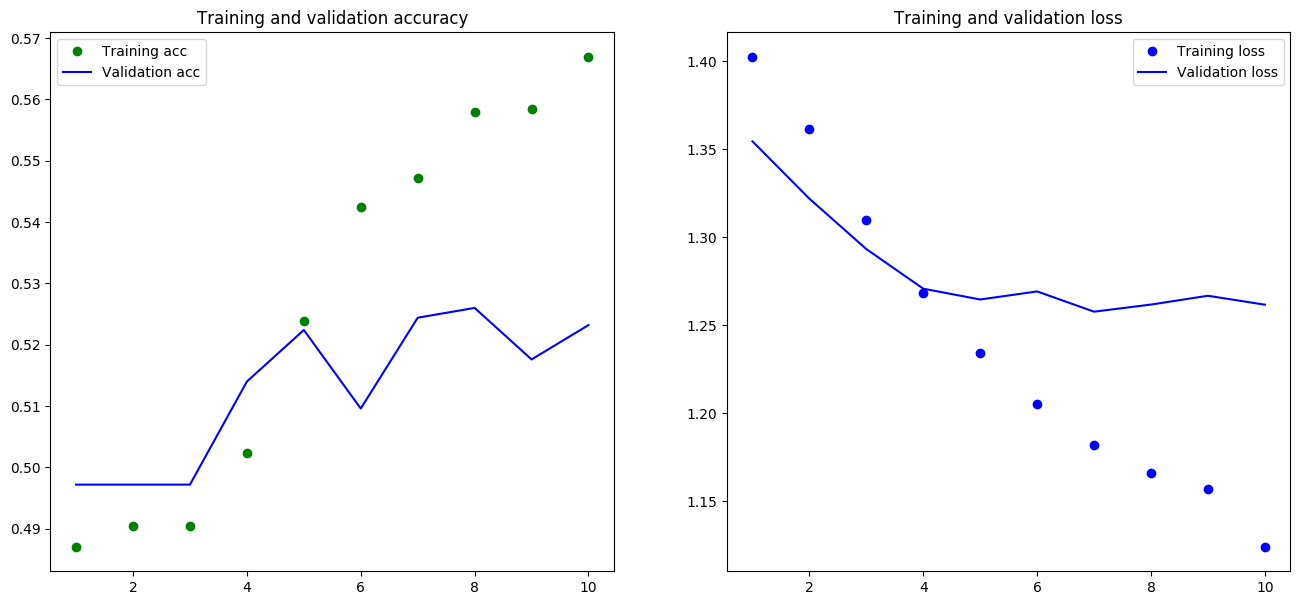

In [32]:
plot_history(cnn)

In [33]:
model3_score_test = model3.evaluate(model3_train, one_hot_labels, batch_size=32)
model3_score_train = model3.evaluate(model3_train, one_hot_labels, batch_size=32)
print("Accuracy for Convolutional Neural Network is ",model3_score_train[1])

10000/10000 [==============================] - 20s 2ms/step
Accuracy for Convolutional Neural Network is  0.5763


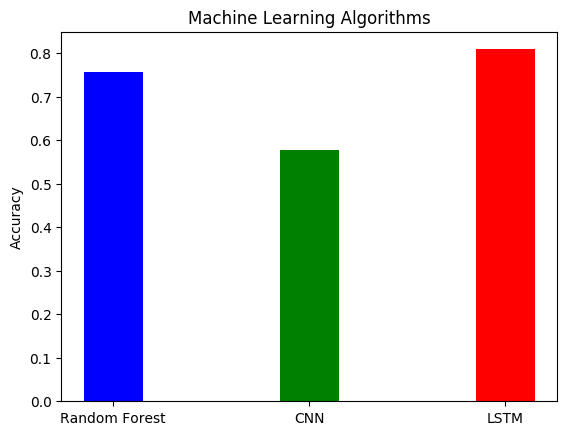

In [34]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Random Forest', 'CNN', 'LSTM')
y_pos = np.arange(len(objects))
performance = (model1_scores,model3_score_train[1],model2_score_train[1],)
width = [0.3,0.3,0.3]

plt.bar(y_pos, performance, align='center', color=['blue','green','red'], width = width)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Machine Learning Algorithms')

plt.show()